In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('../data/ex_train.csv')
val_df = pd.read_csv('../data/ex_val.csv')
test_df = pd.read_csv('../data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [6]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [7]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Single-step model 

### CNN 

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['NO2'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['NO2'])

In [10]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0425 - val_loss: 0.0020 - val_mean_absolute_error: 0.0298
Epoch 2/50
414/414 [==============================] - 0s 964us/step - loss: 0.0018 - mean_absolute_error: 0.0296 - val_loss: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 3/50
414/414 [==============================] - 0s 947us/step - loss: 0.0017 - mean_absolute_error: 0.0278 - val_loss: 0.0019 - val_mean_absolute_error: 0.0287
Epoch 4/50
414/414 [==============================] - 0s 932us/step - loss: 0.0017 - mean_absolute_error: 0.0283 - val_loss: 0.0018 - val_mean_absolute_error: 0.0270
Epoch 5/50
414/414 [==============================] - 0s 937us/step - loss: 0.0016 - mean_absolute_error: 0.0276 - val_loss: 0.0019 - val_mean_absolute_error: 0.0286
Epoch 6/50
414/414 [==============================] - 0s 925us/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0020 - val_mean_absolute_error: 0.0289
Epoch 

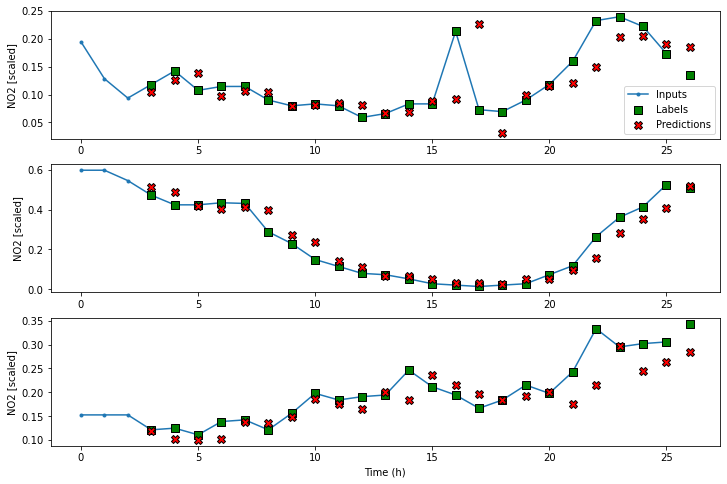

In [13]:
wide_conv_window.plot(cnn_model)

### CNN + LSTM 

In [15]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 4s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0486 - val_loss: 0.0022 - val_mean_absolute_error: 0.0315
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0299 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0284 - val_loss: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0274 - val_loss: 0.0023 - val_mean_absolute_error: 0.0330
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0271 - val_loss: 0.0020 - val_mean_absolute_error: 0.0286
Epoch 6/50
119/119 [==============================] - 0s 924us/step - loss: 0.0020 - mean_absolute_error: 0.0289


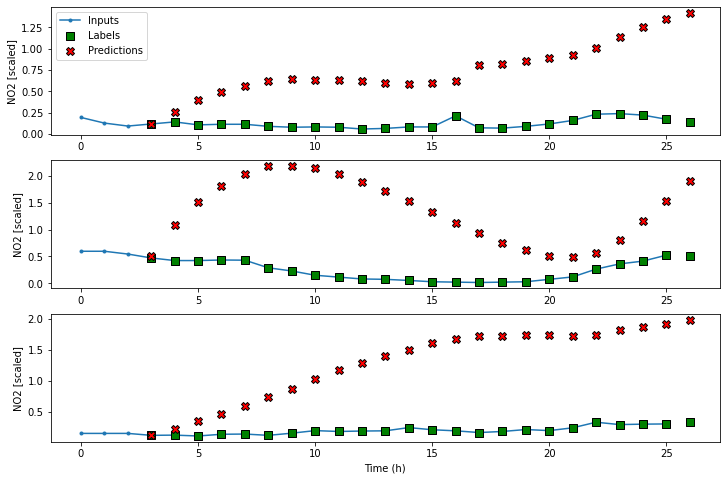

In [16]:
wide_conv_window.plot(cnn_lstm_model)

In [17]:
# Values obtained from chapter 15

mae_val = [0.029, 0.028, 0.029, 0.027]
mae_test = [0.033, 0.032, 0.034, 0.033]

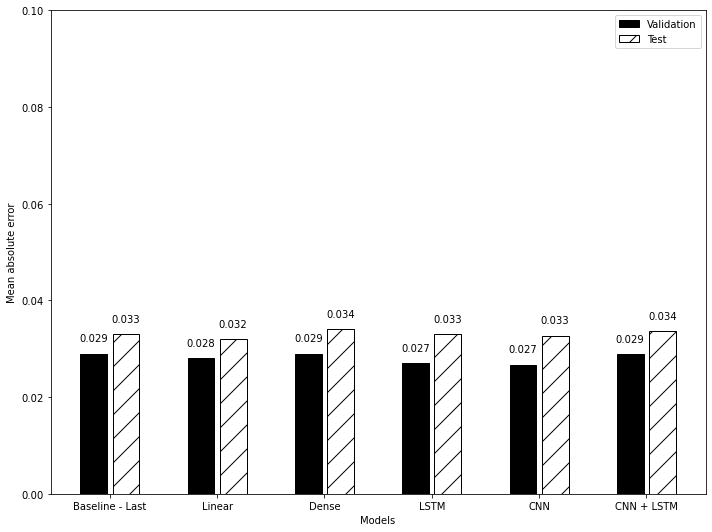

In [18]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model 

### CNN 

In [20]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

In [21]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_conv_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0873 - val_loss: 0.0086 - val_mean_absolute_error: 0.0683
Epoch 2/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0794 - val_loss: 0.0084 - val_mean_absolute_error: 0.0678
Epoch 3/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0107 - mean_absolute_error: 0.0781 - val_loss: 0.0089 - val_mean_absolute_error: 0.0697
Epoch 4/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0085 - val_mean_absolute_error: 0.0687
Epoch 5/50
117/117 [==============================] - 0s 759us/step - loss: 0.0086 - mean_absolute_error: 0.0692


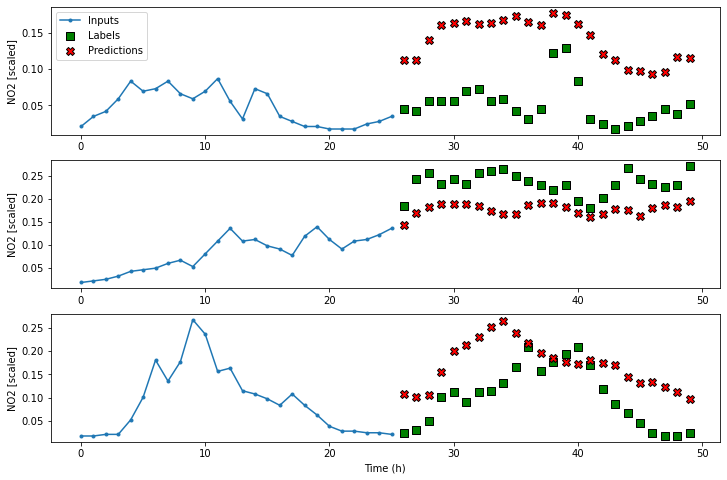

In [22]:
multi_conv_window.plot(ms_cnn_model)

### CNN + LSTM

In [23]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0892 - val_loss: 0.0091 - val_mean_absolute_error: 0.0704
Epoch 2/50
413/413 [==============================] - 2s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0809 - val_loss: 0.0084 - val_mean_absolute_error: 0.0697
Epoch 3/50
413/413 [==============================] - 2s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0787 - val_loss: 0.0097 - val_mean_absolute_error: 0.0725
Epoch 4/50
413/413 [==============================] - 2s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0084 - val_mean_absolute_error: 0.0686
Epoch 5/50
117/117 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0688


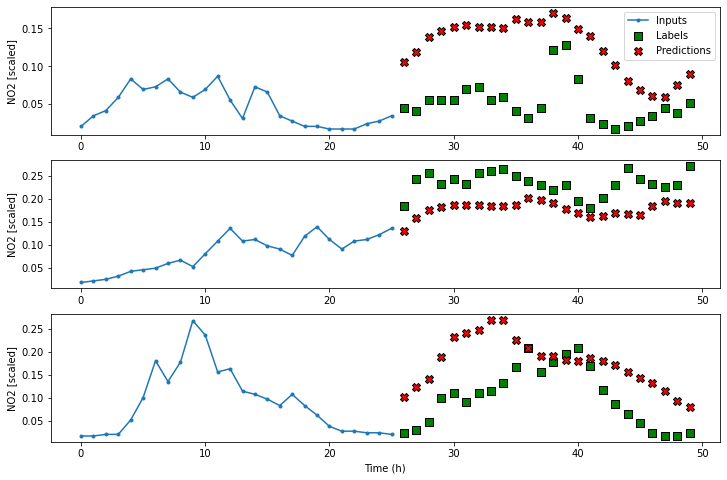

In [24]:
multi_conv_window.plot(ms_cnn_lstm_model)

In [25]:
# Values obtained from chapter 15

ms_mae_val = [0.282, 0.282, 0.070, 0.071, 0.069]
ms_mae_test = [0.243, 0.244, 0.115, 0.114, 0.114]

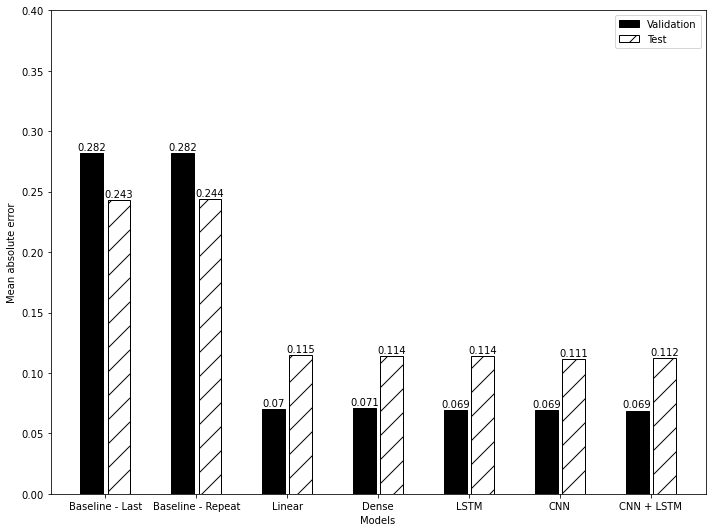

In [26]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model
### CNN

In [27]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['NO2', 'TEMP'])

In [28]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0390 - val_loss: 0.0012 - val_mean_absolute_error: 0.0233
Epoch 2/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0225 - val_loss: 0.0011 - val_mean_absolute_error: 0.0210
Epoch 3/50
413/413 [==============================] - 1s 1ms/step - loss: 9.9132e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0011 - val_mean_absolute_error: 0.0203
Epoch 4/50
413/413 [==============================] - 1s 1ms/step - loss: 9.3238e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0011 - val_mean_absolute_error: 0.0198
Epoch 5/50
413/413 [==============================] - 1s 1ms/step - loss: 8.9681e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0011 - val_mean_absolute_error: 0.0196
Epoch 6/50
413/413 [==============================] - 1s 1ms/step - loss: 8.7819e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0011 - val_mean_absolute_error: 0.0193


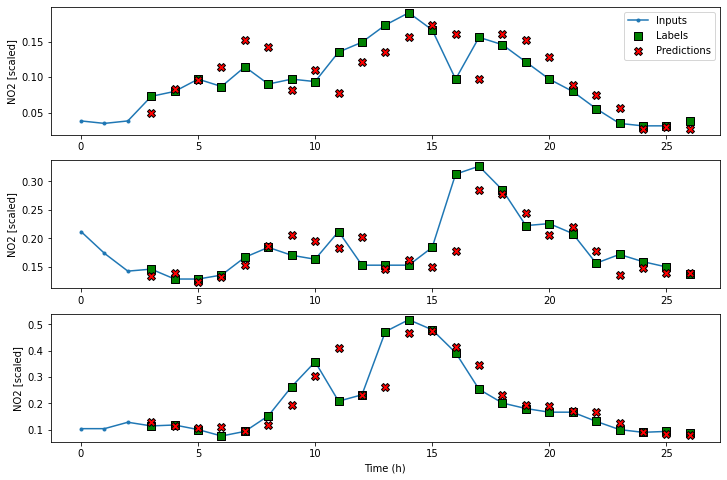

In [29]:
wide_mo_conv_window.plot(mo_cnn_model)

### CNN + LSTM

In [30]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 7ms/step - loss: 0.0061 - mean_absolute_error: 0.0474 - val_loss: 0.0014 - val_mean_absolute_error: 0.0260
Epoch 2/50
413/413 [==============================] - 2s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 3/50
413/413 [==============================] - 2s 6ms/step - loss: 9.9486e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0011 - val_mean_absolute_error: 0.0204
Epoch 4/50
413/413 [==============================] - 3s 6ms/step - loss: 9.3954e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0011 - val_mean_absolute_error: 0.0198
Epoch 5/50
413/413 [==============================] - 2s 6ms/step - loss: 9.0398e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0011 - val_mean_absolute_error: 0.0196
Epoch 6/50
413/413 [==============================] - 3s 6ms/step - loss: 8.8964e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0011 - val_mean_absolute_error: 0.0192


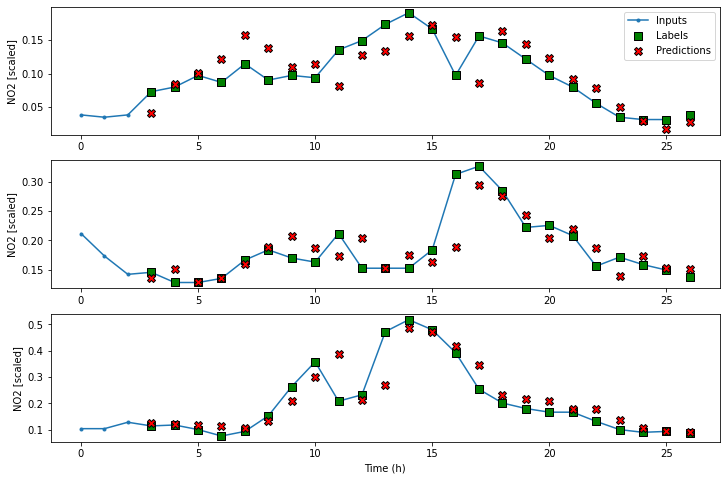

In [34]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

In [32]:
# Values from chapter 15

mo_mae_val = [0.021, 0.020, 0.020, 0.019]
mo_mae_test = [0.025, 0.023, 0.025, 0.022]

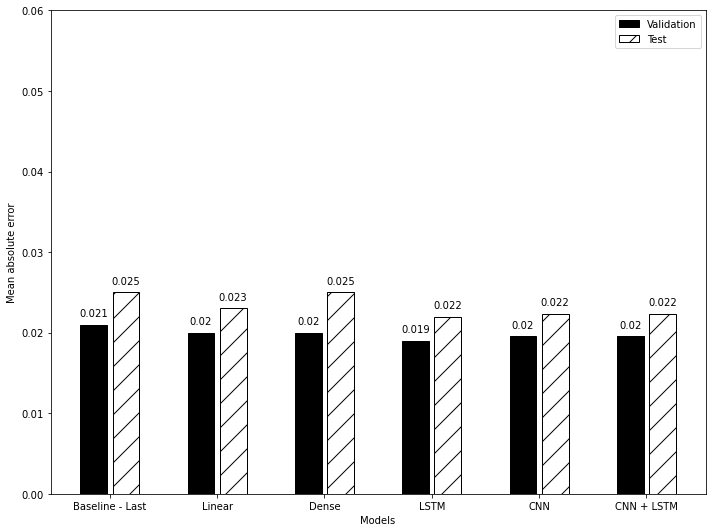

In [33]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()